 
6. Modeling      
6.1. Transformation Pipeline    
6.2. Training on train split      
6.3. Cross-validation   
7. Fine-tuning  
7.1. Hypeparametrization       
7.2. Evaluate on test set   
8. Deployment 

In [1]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.inspection import permutation_importance
import numpy as np
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', context='notebook',font_scale=1.5, color_codes=True)
import matplotlib.pyplot as plt
plt.style.use('ggplot')
np.random.seed(42)

TRAINPATH='/home/miki/Desktop/Deployment/survival-analysis/data/trainds/train.csv'
TESTPATH='/home/miki/Desktop/Deployment/survival-analysis/data/testds/test.csv'
ACCURACYPATH='/home/miki/Desktop/Deployment/survival-analysis/reports/accuracy.csv'
MODELPATH='/home/miki/Desktop/Deployment/survival-analysis/output/model.pkl'

In [2]:
traindf = pd.read_csv('/home/miki/Desktop/Deployment/survival-analysis/data/trainds/train.csv')
X_train = traindf.drop(['Event'], axis = 1)
y_train = traindf['Event']

In [3]:
cols_to_scale =  ['Time of 1st coll', 'Method of co. feeding', 'Amount of liquid diet', 'Parity of the dam', 'Weaning age', 'Cleaness of the barn', 'Housing', 'Education', 'Herd size', 'Age of the farm', 'Source of income', 'Owner ship', 'Sex of cc', 'Experience']
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
preprocessor = ColumnTransformer(remainder='drop',
                                 transformers=[('num', numeric_transformer, cols_to_scale)])
clf = Pipeline(steps=[('preprocessor', preprocessor), 
                        ('classifier', SVC( kernel='rbf',random_state=42))
                        ])

In [4]:
clf.fit(X_train, y_train)

print('Training set score: ' + str(clf.score(X_train,y_train)))

Training set score: 0.9387755102040817


In [5]:
testdf = pd.read_csv('/home/miki/Desktop/Deployment/survival-analysis/data/testds/test.csv')
X_test = testdf.drop(['Event'], axis = 1)
y_test = testdf['Event']

In [6]:
clf.score(X_test,y_test)

0.96

In [7]:
preds = clf.predict(X_test)

In [8]:
print(confusion_matrix(y_test, preds))
print(classification_report(y_test, preds))

[[15  0]
 [ 1  9]]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        15
           1       1.00      0.90      0.95        10

    accuracy                           0.96        25
   macro avg       0.97      0.95      0.96        25
weighted avg       0.96      0.96      0.96        25



In [9]:
print("Accuracy Score:", accuracy_score(y_test, preds))
print("Recall Score:", recall_score(y_test, preds))
print("F1 Score:", f1_score(y_test, preds))
print("Precision Score:", precision_score(y_test, preds))
print("ROC AUC Score: ", roc_auc_score(y_test, preds))
sc_fp, sc_tp, sc_threshold = roc_curve(y_test, preds)
print("Threshold:", sc_threshold)

Accuracy Score: 0.96
Recall Score: 0.9
F1 Score: 0.9473684210526316
Precision Score: 1.0
ROC AUC Score:  0.95
Threshold: [2 1 0]


In [10]:
accs = accuracy_score(y_test, preds)
reccs = recall_score(y_test, preds)
f1 = f1_score(y_test, preds)
presc = precision_score(y_test, preds),
resc = roc_auc_score(y_test, preds)

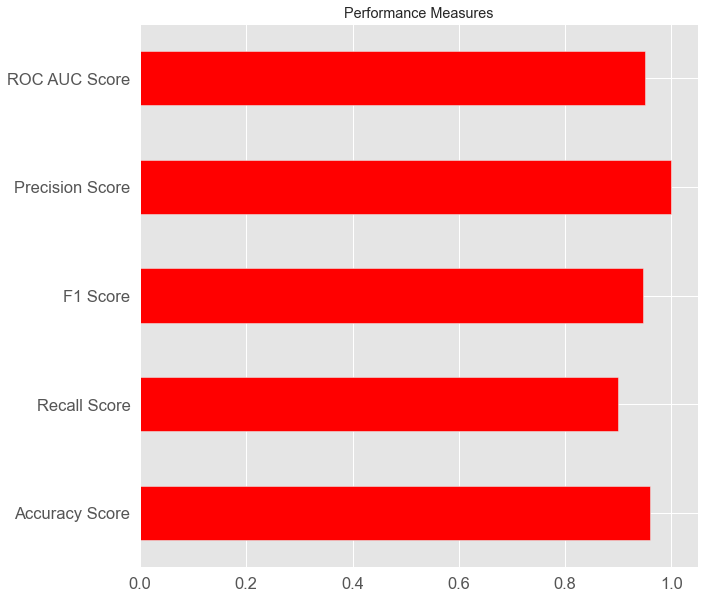

In [11]:
# Visualize cross-validated metrics
accuracy_metrics = pd.DataFrame({"Accuracy Score": accs,
                                "Recall Score": reccs,
                                "F1 Score": f1,
                                "Precision Score": presc,
                                "ROC AUC Score": resc},
                          index=[0])
accuracy_metrics.to_csv("/home/miki/Desktop/Deployment/survival-analysis/reports/accuracy.csv")
accuracy_metrics.T.plot.barh(title="Performance Measures",
                      color = 'Red',  legend=False, figsize=(10,10));

In [12]:
def auc_plot(x = None, y = None):
    """Function to plot the AUC
    =============================
    ARGUMENTS:
    x: int or float ==> False Positive
    y: int or float ==> True Positive
    =============================
    """
    plt.figure(figsize=(20,10))
    plt.plot([0, 1], [0, 1], linestyle = "--")
    plt.plot(x, y, color="red", label = "Support Vector Machine") 
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()

In [13]:
def matrix_plot(x = None, y = None):
    """Function to plot Matrix
    ============================
    ARGUMENTS:
    x:(target label) int or float 
    y: (predicted label) int or float
    ============================"""
    class_names=[False, True] # name  of classes
    fig, ax = plt.subplots(figsize=(5, 5))
    sns.heatmap(confusion_matrix(y_test,preds), annot=True, cmap="YlGnBu", fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    tick_marks = [0.5, 1.5]
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    plt.show();

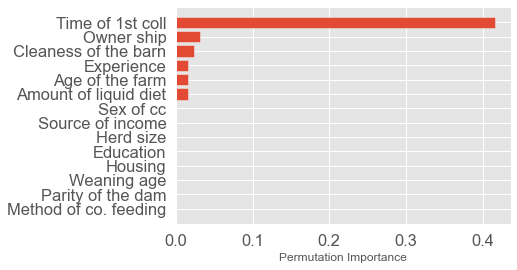

In [14]:
perm_importance = permutation_importance(clf, X_test, y_test)
cols_to_scale =  ['Time of 1st coll', 'Method of co. feeding', 'Amount of liquid diet', 'Parity of the dam', 'Weaning age', 'Cleaness of the barn', 'Housing', 'Education', 'Herd size', 'Age of the farm', 'Source of income', 'Owner ship', 'Sex of cc', 'Experience']
features = np.array(cols_to_scale)
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance");

In [15]:
import pickle
pickle_out = open("/home/miki/Desktop/Deployment/survival-analysis/output/model.pkl", "wb")
pickle.dump(clf, pickle_out)
pickle_out.close()